In [1]:
import sys
sys.path.append("../code/")
from common import APPLIANCES_ORDER
import tflearn
import tensorflow as tf

APPLIANCES_ORDER

/Users/nipun/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


['aggregate', 'hvac', 'fridge', 'mw', 'dw', 'wm', 'oven']

In [2]:
import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
tensor = np.load('../1H-input.npy')

In [4]:
tensor[:, :, 180:194,:].shape

(320, 7, 14, 24)

In [5]:
def create_subset_dataset(tensor):
    t_subset = tensor[:, :, 180:194, :]
    all_indices = np.array(list(range(320)))
    for i in range(1, 7):
        valid_homes = pd.DataFrame(t_subset[:, i, :].reshape(320, 14*24)).dropna().index
        all_indices = np.intersect1d(all_indices, valid_homes)
    t_subset = t_subset[all_indices, :, :, :].reshape(52, 7, 14*24)
    
    # Create artificial aggregate
    t_subset[:, 0, :] = 0.0
    for i in range(1, 7):
        t_subset[:, 0, :] = t_subset[:, 0, :] + t_subset[:, i, :]
    # t_subset is of shape (#home, appliance, days*hours)
    return t_subset, all_indices

In [6]:
t_all, valid_homes = create_subset_dataset(tensor)
t_all.shape

(52, 7, 336)

In [7]:
train_agg = t_all[:30, 0, :].reshape(30*14, 24, 1)
train_hvac = t_all[:30, 1, :].reshape(30*14, 24, 1)

test_hvac = t_all[30:, 1, :].reshape(22*14, 24, 1)
test_agg = t_all[30:, 0, :].reshape(22*14, 24, 1)

In [8]:
from random import randint
from numpy import array
from numpy import argmax
from numpy import array_equal
import keras
from keras.models import Sequential
from keras.layers import LSTM, Flatten
from keras.layers import Dense, Input
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
from keras.layers.merge import Minimum
from attention import AttentionDecoder

Using TensorFlow backend.


In [24]:
import seq2seq
from seq2seq.models import AttentionSeq2Seq

model = AttentionSeq2Seq(input_dim=1, input_length=24, hidden_dim=100, output_length=24, output_dim=1, depth=10, bidirectional=False)
model.compile(loss='mse', optimizer='adam')

In [28]:
hist = model.fit(train_agg/5000., train_hvac/5000., epochs=5, verbose=2, validation_split=0.2)


Train on 336 samples, validate on 84 samples
Epoch 1/5
 - 5s - loss: 0.0220 - val_loss: 0.0189
Epoch 2/5
 - 5s - loss: 0.0218 - val_loss: 0.0185
Epoch 3/5
 - 5s - loss: 0.0214 - val_loss: 0.0193
Epoch 4/5
 - 5s - loss: 0.0216 - val_loss: 0.0182
Epoch 5/5
 - 5s - loss: 0.0211 - val_loss: 0.0200


In [29]:
pred_hvac = model.predict(test_agg/5000.)*5000.

In [34]:
pd.DataFrame(pred_hvac.reshape(-1, 24))

0      250.016769
1      250.016769
2      250.016769
3      250.016769
4      250.016769
5      250.016769
6      250.016769
7      250.016769
8      250.016769
9      250.016769
10     250.016769
11     250.016769
12     250.016769
13     250.016769
14     250.016769
15     250.016769
16     250.016769
17     250.016769
18     250.016769
19     250.016769
20     250.016769
21     250.016769
22     250.016769
23     250.016769
24     250.016769
25     250.016769
26     250.016769
27     250.016769
28     250.016769
29     250.016769
          ...    
278    250.016769
279    250.016769
280    250.016769
281    250.016769
282    250.016769
283    250.016769
284    250.016769
285    250.016769
286    250.016769
287    250.016769
288    250.016769
289    250.016769
290    250.016769
291    250.016769
292    250.016769
293    250.016769
294    250.016769
295    250.016769
296    250.016769
297    250.016769
298    250.016769
299    250.016769
300    250.016769
301    250.016769
302    250

In [30]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(test_hvac.flatten(), pred_hvac.flatten())

598.39360673675162

In [13]:
from IPython.display import SVG

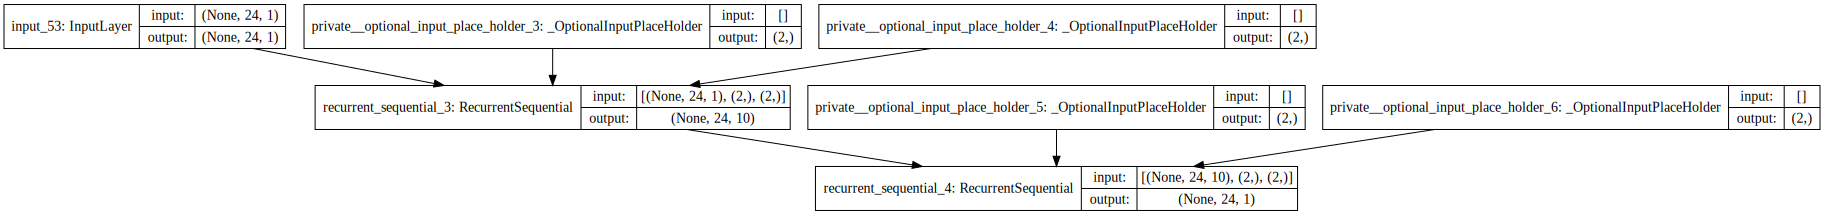

In [14]:
from keras.utils.vis_utils import model_to_dot
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['acc'])
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))



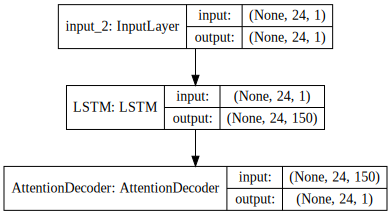

In [13]:
n_features = 1
n_timesteps_in = 24
n_timesteps_out = 24
# define model
input_tensor = Input(shape=(n_timesteps_in, n_features))
lstm1 = LSTM(150,name="LSTM", return_sequences=True)(input_tensor)
at = AttentionDecoder(5, n_features)(lstm1)
#flatten = Flatten()(at)
#clip = Minimum()([flatten, Flatten()(input_tensor)])
model = keras.Model(input_tensor, at)
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['acc'])
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))


In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 24, 1)             0         
_________________________________________________________________
LSTM (LSTM)                  (None, 24, 150)           91200     
_________________________________________________________________
AttentionDecoder (AttentionD (None, 24, 1)             4047      
Total params: 95,247
Trainable params: 95,247
Non-trainable params: 0
_________________________________________________________________


In [15]:
opt = keras.optimizers.SGD(lr=0.0001)
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['acc'])
hist = model.fit(train_agg/5000., train_hvac/5000., epochs=50, verbose=2, validation_split=0.2)
pred_hvac = 5000.*model.predict(test_agg/5000.)
#pred_hvac[pred_hvac>test_agg] = test_agg[pred_hvac>test_agg]
from sklearn.metrics import mean_absolute_error
#mean_absolute_error(test_hvac[:, :, 0], pred_hvac[:, :])

Train on 336 samples, validate on 84 samples
Epoch 1/50
 - 2s - loss: 0.8287 - acc: 0.0000e+00 - val_loss: 0.8221 - val_acc: 0.0000e+00
Epoch 2/50
 - 1s - loss: 0.8287 - acc: 0.0000e+00 - val_loss: 0.8221 - val_acc: 0.0000e+00
Epoch 3/50
 - 1s - loss: 0.8287 - acc: 0.0000e+00 - val_loss: 0.8221 - val_acc: 0.0000e+00
Epoch 4/50
 - 1s - loss: 0.8287 - acc: 0.0000e+00 - val_loss: 0.8221 - val_acc: 0.0000e+00
Epoch 5/50
 - 1s - loss: 0.8287 - acc: 0.0000e+00 - val_loss: 0.8221 - val_acc: 0.0000e+00
Epoch 6/50
 - 1s - loss: 0.8287 - acc: 0.0000e+00 - val_loss: 0.8221 - val_acc: 0.0000e+00
Epoch 7/50
 - 1s - loss: 0.8287 - acc: 0.0000e+00 - val_loss: 0.8221 - val_acc: 0.0000e+00
Epoch 8/50
 - 1s - loss: 0.8287 - acc: 0.0000e+00 - val_loss: 0.8221 - val_acc: 0.0000e+00
Epoch 9/50
 - 1s - loss: 0.8287 - acc: 0.0000e+00 - val_loss: 0.8221 - val_acc: 0.0000e+00
Epoch 10/50
 - 1s - loss: 0.8287 - acc: 0.0000e+00 - val_loss: 0.8221 - val_acc: 0.0000e+00
Epoch 11/50
 - 1s - loss: 0.8287 - acc: 0.00

KeyboardInterrupt: 

In [32]:
hist.history['val_loss']

[888.61864653087798,
 888.61864653087798,
 888.61864653087798,
 888.61864653087798,
 888.61864653087798,
 888.61864653087798,
 888.61864653087798,
 888.61864653087798,
 888.61864653087798,
 888.61864653087798,
 888.61864653087798,
 888.61864653087798,
 888.61864653087798,
 888.61864653087798,
 888.61864653087798,
 888.61864653087798,
 888.61864653087798,
 888.61864653087798,
 888.61864653087798,
 888.61864653087798,
 888.61864653087798,
 888.61864653087798,
 888.61864653087798,
 888.61864653087798,
 888.61864653087798,
 888.61864653087798,
 888.61864653087798,
 888.61864653087798,
 888.61864653087798,
 888.61864653087798,
 888.61864653087798,
 888.61864653087798,
 888.61864653087798,
 888.61864653087798,
 888.61864653087798,
 888.61864653087798,
 888.61864653087798,
 888.61864653087798,
 888.61864653087798,
 888.61864653087798,
 888.61864653087798,
 888.61864653087798,
 888.61864653087798,
 888.61864653087798,
 888.61864653087798,
 888.61864653087798,
 888.61864653087798,
 888.61864653

In [12]:
pd.Series(hist.history['val-loss']).plot()

NameError: name 'hist' is not defined

In [30]:
pred_hvac

array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       ..., 
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.]], dtype=float32)

In [31]:
test_agg.shape

(308, 24, 1)

In [32]:
pred_hvac.shape

(308, 24)

In [33]:
pred_hvac = pred_hvac.reshape(22, )

ValueError: cannot reshape array of size 7392 into shape (22,)

In [34]:
import matplotlib.pyplot as plt

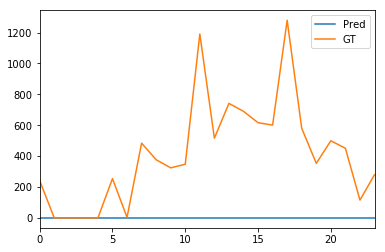

In [35]:
pd.Series(model.predict(test_agg[1:2]).squeeze()).plot(label='Pred')
pd.Series(test_hvac[1:2].squeeze()).plot(label="GT")
plt.legend()
#plt.ylim((0, 100))
#plt.axhline(80, color='k',alpha=0.5, marker='*', linestyle='--')

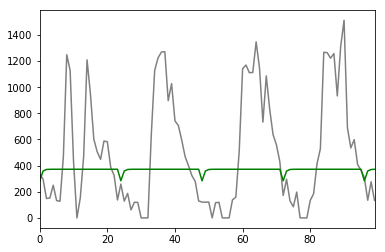

In [41]:
pd.DataFrame(test_hvac.reshape(22,14*24)).T.head(100)[1].plot(color='grey',alpha=1)
pd.DataFrame(model.predict(test_hvac).reshape(22,14*24)).T.head(100)[1].plot(color='g',alpha=1)

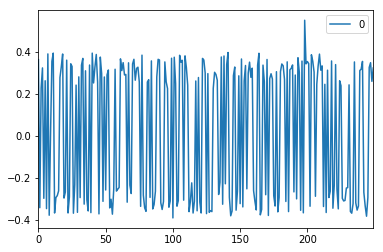

In [243]:
pd.DataFrame(model.get_weights()[6]).plot()

TypeError: Invalid dimensions for image data

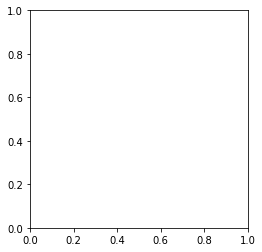

In [250]:
plt.imshow(model.get_weights()[5])

In [226]:
pred_hvac.std()

8.1118002

In [184]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.

In [322]:
#pred = {}
# Predict HVAC using Aggregate data. No RNN for now.
for appliance_name in APPLIANCES_ORDER[1:]:
    appliance_num = APPLIANCES_ORDER.index(appliance_name)
    tf.reset_default_graph()
    print(appliance_num, appliance_name)
    print("*"*80)
    train_all = t_all[:20, :, :]
    validation_all = t_all[20:30, :, :]
    test_all = t_all[30:, :, :]
    train_agg = train_all[:, 0, :]
    train_appliance = train_all[:, appliance_num, :]
    validation_agg = validation_all[:, 0, :]
    validation_appliance = validation_all[:, appliance_num, :]
    
    net = tflearn.input_data(shape=[None, 336])
    net = tflearn.fully_connected(net, 1000, activation='relu')
    net = tflearn.dropout(net, 0.8)
    net = tflearn.fully_connected(net, 1000, activation='relu')
    net = tflearn.dropout(net, 0.8)
    net = tflearn.fully_connected(net, 1000, activation='relu')
    net = tflearn.dropout(net, 0.8)
    
    
    #net = tflearn.fully_connected(net, 1000, activation='relu')
    #net = tflearn.dropout(net, 0.8)
    #net = tflearn.fully_connected(net, 1000, activation='relu')
    #net = tflearn.dropout(net, 0.8)
    
    #net = tflearn.fully_connected(net, 336, activation='relu')
    #net = tflearn.dropout(net, 0.8)
    #net = tflearn.fully_connected(net, 336, activation='relu')
    #net = tflearn.dropout(net, 0.8)
    
    net = tflearn.fully_connected(net, 336, activation='linear')
    net = tflearn.regression(net, loss=my_objective, learning_rate=1e-3, )
    #tflearn.lstm()
    model = tflearn.DNN(net, )
    # Start training (apply gradient descent algorithm)
    model.fit(train_agg ,train_appliance, n_epoch=30, batch_size=20, show_metric=True, 
          validation_set=(validation_agg, validation_appliance))
    agg = test_all[:, 0, :]
    prediction = model.predict(test_all[:, 0, :])
    prediction[prediction>agg] = agg[prediction>agg]
    prediction[prediction<0.] = 0.
    pred[appliance_name] = model.predict(test_all[:, 0, :])

1 hvac
********************************************************************************
---------------------------------
Run id: SHAB6A
Log directory: /tmp/tflearn_logs/
INFO:tensorflow:Summary name Accuracy/ (raw) is illegal; using Accuracy/__raw_ instead.
---------------------------------
Training samples: 20
Validation samples: 10
--
Training Step: 1  | time: 1.149s
| Adam | epoch: 001 | loss: 0.00000 - acc: 0.0000 | val_loss: 750.52991 - val_acc: 0.0000 -- iter: 20/20
--
Training Step: 2  | total loss: 802.54767 | time: 1.029s
| Adam | epoch: 002 | loss: 802.54767 - acc: 0.0000 | val_loss: 538.16461 - val_acc: 0.0000 -- iter: 20/20
--
Training Step: 3  | total loss: 809.46259 | time: 1.031s
| Adam | epoch: 003 | loss: 809.46259 - acc: 0.0000 | val_loss: 865.19421 - val_acc: 0.0000 -- iter: 20/20
--
Training Step: 4  | total loss: 660.16187 | time: 1.031s
| Adam | epoch: 004 | loss: 660.16187 - acc: 0.0000 | val_loss: 842.42700 - val_acc: 0.0000 -- iter: 20/20
--
Training Step: 5  

Training Step: 13  | total loss: 39.19313 | time: 1.027s
| Adam | epoch: 013 | loss: 39.19313 - acc: 0.0083 | val_loss: 39.32504 - val_acc: 0.1000 -- iter: 20/20
--
Training Step: 14  | total loss: 36.71993 | time: 1.030s
| Adam | epoch: 014 | loss: 36.71993 - acc: 0.0049 | val_loss: 43.92396 - val_acc: 0.2000 -- iter: 20/20
--
Training Step: 15  | total loss: 39.92056 | time: 1.027s
| Adam | epoch: 015 | loss: 39.92056 - acc: 0.0030 | val_loss: 38.69132 - val_acc: 0.1000 -- iter: 20/20
--
Training Step: 16  | total loss: 44.11729 | time: 1.031s
| Adam | epoch: 016 | loss: 44.11729 - acc: 0.0019 | val_loss: 37.62862 - val_acc: 0.1000 -- iter: 20/20
--
Training Step: 17  | total loss: 42.57297 | time: 1.030s
| Adam | epoch: 017 | loss: 42.57297 - acc: 0.0012 | val_loss: 46.17460 - val_acc: 0.0000 -- iter: 20/20
--
Training Step: 18  | total loss: 37.89741 | time: 1.030s
| Adam | epoch: 018 | loss: 37.89741 - acc: 0.0008 | val_loss: 47.92051 - val_acc: 0.0000 -- iter: 20/20
--
Training S

Training Step: 27  | total loss: 5.33169 | time: 1.040s
| Adam | epoch: 027 | loss: 5.33169 - acc: 0.0000 | val_loss: 5.13021 - val_acc: 0.0000 -- iter: 20/20
--
Training Step: 28  | total loss: 5.28565 | time: 1.038s
| Adam | epoch: 028 | loss: 5.28565 - acc: 0.0000 | val_loss: 5.07062 - val_acc: 0.0000 -- iter: 20/20
--
Training Step: 29  | total loss: 5.21250 | time: 1.040s
| Adam | epoch: 029 | loss: 5.21250 - acc: 0.0000 | val_loss: 5.29079 - val_acc: 0.0000 -- iter: 20/20
--
Training Step: 30  | total loss: 5.15394 | time: 1.039s
| Adam | epoch: 030 | loss: 5.15394 - acc: 0.0000 | val_loss: 5.28192 - val_acc: 0.0000 -- iter: 20/20
--
4 dw
********************************************************************************
---------------------------------
Run id: XBRGXH
Log directory: /tmp/tflearn_logs/
INFO:tensorflow:Summary name Accuracy/ (raw) is illegal; using Accuracy/__raw_ instead.
---------------------------------
Training samples: 20
Validation samples: 10
--
Training Step:

Training Step: 9  | total loss: 5.35197 | time: 1.030s
| Adam | epoch: 009 | loss: 5.35197 - acc: 0.0326 | val_loss: 4.72790 - val_acc: 0.0000 -- iter: 20/20
--
Training Step: 10  | total loss: 5.08192 | time: 1.025s
| Adam | epoch: 010 | loss: 5.08192 - acc: 0.0163 | val_loss: 4.72785 - val_acc: 0.0000 -- iter: 20/20
--
Training Step: 11  | total loss: 4.91905 | time: 1.028s
| Adam | epoch: 011 | loss: 4.91905 - acc: 0.0086 | val_loss: 4.72768 - val_acc: 0.0000 -- iter: 20/20
--
Training Step: 12  | total loss: 4.82743 | time: 1.027s
| Adam | epoch: 012 | loss: 4.82743 - acc: 0.0047 | val_loss: 4.72747 - val_acc: 0.0000 -- iter: 20/20
--
Training Step: 13  | total loss: 4.76804 | time: 1.027s
| Adam | epoch: 013 | loss: 4.76804 - acc: 0.0241 | val_loss: 4.72729 - val_acc: 0.0000 -- iter: 20/20
--
Training Step: 14  | total loss: 4.73165 | time: 1.023s
| Adam | epoch: 014 | loss: 4.73165 - acc: 0.0347 | val_loss: 4.72715 - val_acc: 0.1000 -- iter: 20/20
--
Training Step: 15  | total lo

Training Step: 23  | total loss: 12.58414 | time: 1.032s
| Adam | epoch: 023 | loss: 12.58414 - acc: 0.0106 | val_loss: 12.99475 - val_acc: 0.0000 -- iter: 20/20
--
Training Step: 24  | total loss: 12.45188 | time: 1.031s
| Adam | epoch: 024 | loss: 12.45188 - acc: 0.0077 | val_loss: 13.29540 - val_acc: 0.0000 -- iter: 20/20
--
Training Step: 25  | total loss: 12.52920 | time: 1.026s
| Adam | epoch: 025 | loss: 12.52920 - acc: 0.0056 | val_loss: 13.81957 - val_acc: 0.0000 -- iter: 20/20
--
Training Step: 26  | total loss: 12.91152 | time: 1.026s
| Adam | epoch: 026 | loss: 12.91152 - acc: 0.0041 | val_loss: 13.35557 - val_acc: 0.0000 -- iter: 20/20
--
Training Step: 27  | total loss: 12.70777 | time: 1.027s
| Adam | epoch: 027 | loss: 12.70777 - acc: 0.0030 | val_loss: 13.02467 - val_acc: 0.0000 -- iter: 20/20
--
Training Step: 28  | total loss: 12.53592 | time: 1.031s
| Adam | epoch: 028 | loss: 12.53592 - acc: 0.0023 | val_loss: 12.86399 - val_acc: 0.0000 -- iter: 20/20
--
Training S

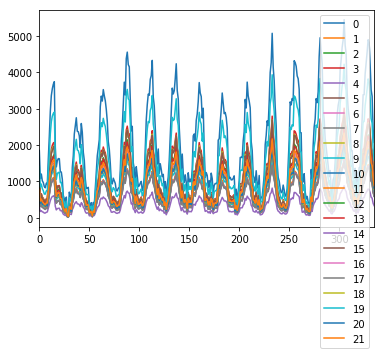

In [323]:
pd.DataFrame(pred['hvac']).T.plot()

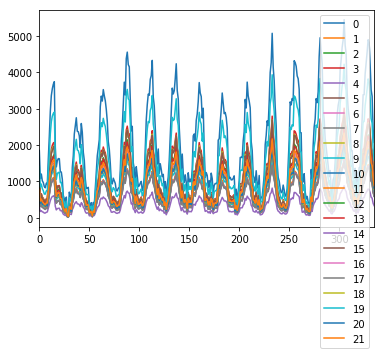

In [324]:
pd.DataFrame(pred['hvac']).T.plot()

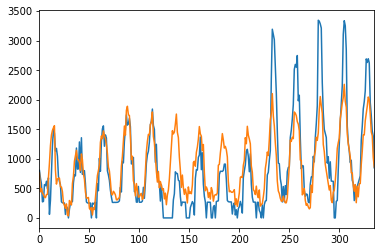

In [325]:
#pd.Series(test_all[21, 0, :]).plot()
appliance="hvac"
appliance_num = APPLIANCES_ORDER.index(appliance)
home = 2
pd.Series(test_all[home, appliance_num, :]).plot()


pd.Series(pred[appliance][home, :]).plot()

In [326]:
gt = tensor[valid_homes, :, 180:194, :][30:, :, :, :].reshape(22, 7, 336)

In [327]:
err = {}
for appliance in APPLIANCES_ORDER[1:]:
    appliance_num = APPLIANCES_ORDER.index(appliance)
    x = pred[appliance]
    x[x<0.] = 0.
    err[appliance] = np.abs(x-gt[:,appliance_num,:]).mean()
err

{'dw': 14.499282748441475,
 'fridge': 38.963289293411158,
 'hvac': 400.58428677382278,
 'mw': 6.0473137386404012,
 'oven': 18.841750304140575,
 'wm': 5.6176747577812591}

In [320]:
err = {}
for appliance in APPLIANCES_ORDER[1:]:
    appliance_num = APPLIANCES_ORDER.index(appliance)
    x = pred[appliance]
    x[x<0.] = 0.
    err[appliance] = np.abs(x-gt[:,appliance_num,:]).mean()
err

{'dw': 14.705560667027434,
 'fridge': 42.818390235146587,
 'hvac': 393.80620519751915,
 'mw': 6.2404866278266287,
 'oven': 19.633836841761177,
 'wm': 5.8684080275200738}

<tf.Tensor 'read:0' shape=(336, 336) dtype=float32>

In [66]:
pd.Series(err)

dw         24.501916
fridge     40.642623
hvac      407.645032
mw          9.477331
oven       24.559614
wm          9.269064
dtype: float64

In [44]:
err = {}
for appliance in APPLIANCES_ORDER[1:]:
    appliance_num = APPLIANCES_ORDER.index(appliance)
    x = pred[appliance]
    x[x<0.] = 0.
    err[appliance] = np.abs(x-gt[:,appliance_num,:]).mean()
err

{'dw': 24.870927145657255,
 'fridge': 40.642622669315109,
 'hvac': 407.64503194612212,
 'mw': 9.5177636509070478,
 'oven': 24.630917072655215,
 'wm': 9.4858786798710284}

In [46]:
pd.Series(err).mean()

86.13219019408797

In [50]:
(pd.DataFrame(pred['hvac'])-pd.DataFrame(gt[:,1,:])).abs().sum(axis=1)

0      76795.709343
1      90376.204248
2     107125.516512
3     154093.437996
4      75034.047701
5     112149.631845
6     161112.576504
7     126881.272907
8     125538.213085
9     189063.335770
10    215992.330513
11    205689.315586
12    214037.400083
13     88024.450001
14     88011.922891
15    162560.397587
16    102536.124285
17     76096.244452
18    194650.624890
19    126364.546612
20    210910.802409
21    110267.970926
dtype: float64

In [495]:
pd.DataFrame(err_sc).min(axis=1)

dw        98.465801
fridge    65.367590
hvac      76.061186
mw        69.195618
oven      59.718504
wm        50.857821
dtype: float64

In [51]:
def accuracy_pie_chart(ground_truth_appliance, prediction_appliance, gt_aggregate):
    out = 0.
    for i in range(6):
        out = out + min(np.sum(ground_truth_appliance[:, i, :]), np.sum(prediction_appliance[:, i, :]))
    return out/np.sum(gt_aggregate)    

In [55]:
approach_pred = {'Neural':pred}

pie_accuracies = {}
for approach_name, approach_prediction in approach_pred.items():
    pie_accuracies[approach_name] = accuracy_pie_chart(gt, approach_prediction, test_all[:, 0, :])

TypeError: unhashable type: 'slice'

Text(0,0.5,'Pie-chart energy breakdown \nproportion correctly identified\n(Higher is better)')

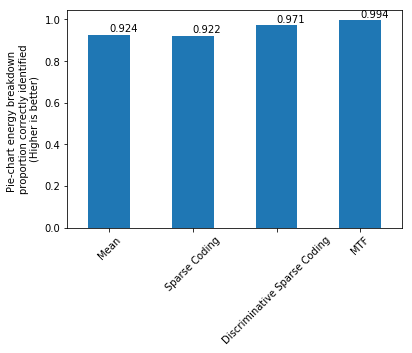

In [526]:
pie_accuracies = pd.Series(pie_accuracies).loc[['Mean','Sparse Coding','Discriminative Sparse Coding','MTF']]
ax = pie_accuracies.plot(kind='bar',rot=45)
for i, v in enumerate(pie_accuracies):
    ax.text( i,v+0.03, str(v.round(3)), va='center')
plt.ylabel("Pie-chart energy breakdown \nproportion correctly identified\n(Higher is better)")

In [522]:
pd.Series(pie_accuracies).

Discriminative Sparse Coding    0.971380
MTF                             0.994402
Mean                            0.923875
Sparse Coding                   0.921797
dtype: float64

In [487]:
mean_pred = np.zeros_like(pred_mtf)
mean_pred[:, :, :] = train_data.mean(axis=2)

In [488]:
mean_pred.shape

(22, 6, 336)

In [490]:
err_mean

{'dw': 101.42720929364509,
 'fridge': 76.717538971029512,
 'hvac': 78.719166409204803,
 'mw': 72.453527550654172,
 'oven': 65.686567624501521,
 'wm': 73.401499222720375}